# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

**Description of the plans**

Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

Surf

1. Monthly charge: $20

2. 500 monthly minutes, 50 texts, and 15 GB of data
3. After exceeding the package limits:
    * 1 minute: 3 cents
    * 1 text message: 3 cents
    * 1 GB of data: $10
    
Ultimate
1. Monthly charge: $70

2. 3000 monthly minutes, 1000 text messages, and 30 GB of data
3. After exceeding the package limits:
    * 1 minute: 1 cent
    * 1 text message: 1 cent
    * 1 GB of data: $7

## Initialization

Let's import all possible libraries.

In [1]:
# Loading all the libraries
from scipy import stats
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import reduce

## Load data

Let's load all data using `try-except`.

In [2]:
# Load the data files into different DataFrames
try:
    calls=pd.read_csv('megaline_calls.csv')
    internet=pd.read_csv('megaline_internet.csv')
    messages=pd.read_csv('megaline_messages.csv')
    plans=pd.read_csv('megaline_plans.csv')
    users=pd.read_csv('megaline_users.csv')
except:
    plans=pd.read_csv('/datasets/megaline_plans.csv')
    users=pd.read_csv('/datasets/megaline_users.csv') 
    calls=pd.read_csv('/datasets/megaline_calls.csv')
    internet=pd.read_csv('/datasets/megaline_internet.csv')
    messages=pd.read_csv('/datasets/megaline_messages.csv')

## Prepare the data

Our data is splitted in different tables, as shown above:
* `plans`
* `users`
* `calls`
* `internet`
* and `messages`

We will explore the raw data using `.info()`, `.head()` and `.describe()` (for the numeric variables). 

### `plans`

In [3]:
# Print the general/summary information about the plans' DataFrame
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Print a sample of data for plans
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The `plans` table :
* `messages_included` — monthly text allowance
* `mb_per_month_included` — data volume allowance (in megabytes)
* `minutes_included` — monthly minute allowance
* `usd_monthly_pay` — monthly charge in US dollars
* `usd_per_gb` — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)
* `usd_per_message` — price per text after exceeding the package limits
* `usd_per_minute` — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
* `plan_name` — calling plan name


We have 2 rows with 8 columns therefor we do not need to print the desrcription of the table.
The table describes each prepaid plans -  `surf` and `ultimate`
The table does not have no missing values and we do not need to change anything in the table.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment</h2>
    
Nice introductory part.
    
</div>

### `users`

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,45.486,16.972269,18.0,30.00,46.0,61.00,75.0


In [7]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


The `users` table (data on users):
* `user_id` — unique user identifier
* `first_name` — user's name
* `last_name` — user's last name
* `age` — user's age (years)
* `city` — user's city of residence
* `reg_date` — subscription date (dd, mm, yy)
* `plan` — calling plan name
* `churn_date` — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)


we have 500 different `user_id` with 8 columns.

we will need to change the `reg_date` and `churn_date` variables type from object to datetime.
In the `churn_date` column, we have missing values that we will replace with `None`.


### `calls`

In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [9]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,137735.0,1247.658046,139.416268,1000.0,1128.00,1247.00,1365.00,1499.0
duration,137735.0,6.745927,5.839241,0.0,1.29,5.98,10.69,37.6


In [10]:
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


The `calls` table (data on calls):
* `id` — unique call identifier
* `user_id` — the identifier of the user making the call
* `call_date` — call date
* `duration` call duration (in minutes)


we have 137735 rows and 4 columns and the tabe has no missing values.
we will need to:
* change the variable type in `call_date` to datetime.
* round up the seconds in `duration` to minutes.Even if the call lasted just one second, it will be counted as one minute.
* and create a `month` column.

### `internet`

In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [12]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,104825.0,1242.496361,142.053913,1000.0,1122.00,1236.00,1367.00,1499.00
mb_used,104825.0,366.713701,277.170542,0.0,136.08,343.98,554.61,1693.47


In [13]:
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


The `internet` table (data on web sessions):
* `id` — unique session identifier
* `user_id` — user identifier
* `session_date` — web session date
* `mb_used` — the volume of data spent during the session (in megabytes)

we have 104825 rows, 4 columns and no missing values. We will need to:
* change the variable type in `session_date` column from object to datetime.
* creat a `month` column.

### `messages`

In [14]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


The `messages` table (data on texts):
* `id` — unique text message identifier
* `user_id` — the identifier of the user sending the text
* `message_date` — text message date

we have 76051 rows, 3 columns and no missing values. We will need to:
* change the variable type in `message_date` column from object to datetime.
* and creat a new `month` column.

## Fix and enrich Data

In the next steps we will:
* Convert in each table the date column in to datetime type and creat a new `month` column in the following tables: `calls`, `messages` and `internet` using the `fix_add_date` function.
* fill the missing values in the `users` table with `None` using `.fillna()` method.
* And round up in the `calls` table the seconds to minutes using `.round()` method.

In [16]:
def fix_add_date(data):
    columns = data.columns.tolist()
    idx = [columns.index(x) for x in columns if 'date' in x][0]
    data[columns[idx]] = pd.to_datetime(data[columns[idx]])
    data['month'] = data[columns[idx]].dt.month_name()
    return data

### `Plans`

There is no fixing or enriching that that we will be doing in this table. 

### `Users`

As discussed previously, first we will fill the missing values in `churn_date` with `None` using `.fillna()` method. Then convert the variables in `reg_date` and `churn_date` to a dateframe type and import the `reg_month` (registration month) and the `churn_month` using the `fix_add_date` function.

In [17]:
users.isna().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [18]:
users['churn_date']=users['churn_date'].fillna('None')

In [19]:
users.isna().sum()

user_id       0
first_name    0
last_name     0
age           0
city          0
reg_date      0
plan          0
churn_date    0
dtype: int64

In [20]:
#datetime_change_type(users,reg_date)
users=fix_add_date(users)

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
 8   month       500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 35.3+ KB


In [22]:
users.churn_date.unique()

array(['None', '2018-12-18', '2018-11-16', '2018-09-07', '2018-12-30',
       '2018-10-07', '2018-12-31', '2018-11-24', '2018-11-11',
       '2018-12-12', '2018-11-14', '2018-12-27', '2018-11-29',
       '2018-12-22', '2018-11-30', '2018-10-13', '2018-07-31',
       '2018-12-15', '2018-12-19', '2018-10-03', '2018-10-22',
       '2018-08-16', '2018-12-26', '2018-09-01', '2018-11-21',
       '2018-08-19', '2018-12-10', '2018-09-17', '2018-11-18',
       '2018-09-18'], dtype=object)

We cannot transform the variables in the `churn_date` into datetime type due to the presence of `None` value. Therefor, we will not creat a churn month column. But if we will need to consider only users that have reactivated their plans, we can filter the table by `churn_date == "None"`, if needed.

Now, let's rename the `month` column to `reg_month` using `.rename()` method to not confuse between the month of calls, message and internet count.

In [23]:
users = users.rename(columns={'month':'reg_month'})

In [24]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,None,December
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,None,August
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,None,October
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,None,January
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,None,May


### `Calls`

As mentioned previously, we will:
* convert the variables in the `call_date` into datetime and add the call month in a new column named `month` using the `fix_add_date` function.
* round the seconds into minutes in the `duration` column using `.apply(np.ceil)` method.

In [25]:
calls=fix_add_date(calls)

In [26]:
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,December
1,1000_145,1000,2018-12-27,13.66,December
2,1000_247,1000,2018-12-27,14.48,December
3,1000_309,1000,2018-12-28,5.76,December
4,1000_380,1000,2018-12-30,4.22,December


In [27]:
calls['duration']=calls['duration'].apply(np.ceil)

In [28]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
 4   month      137735 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 5.3+ MB


In [29]:
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,December
1,1000_145,1000,2018-12-27,14.0,December
2,1000_247,1000,2018-12-27,15.0,December
3,1000_309,1000,2018-12-28,6.0,December
4,1000_380,1000,2018-12-30,5.0,December


### `Messages`

Same as previously, we will only convert the variables in the `message_date` into datetime and add the message month in a new column named `month` using the `fix_add_date` function.

In [30]:
messages=fix_add_date(messages)

In [31]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.3+ MB


In [32]:
messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,December
1,1000_160,1000,2018-12-31,December
2,1000_223,1000,2018-12-31,December
3,1000_251,1000,2018-12-27,December
4,1000_255,1000,2018-12-26,December


### `Internet`

And finaly, as priviosly, we will convert the variable type in `session_date` into datetime and add the session month in a new column named `month` using the `fix_add_date` function.

There is no need to round up now the megabyted into gigabytes now. We will do it before calculating the monthly revenue.

In [33]:
internet=fix_add_date(internet)

In [34]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 4.0+ MB


In [35]:
internet.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,December
1,1000_204,1000,2018-12-31,0.00,December
2,1000_379,1000,2018-12-28,660.40,December
3,1000_413,1000,2018-12-26,270.99,December
4,1000_442,1000,2018-12-27,880.22,December


### Intermediate  conclusion

we did the following:
* filled the missing values in `churn_date` with `None` to indetified (if need further) the users who have reactivated their plans. 
* converterd the variables in `call_date`, `message_date` and `session_date` into datetime and imported for eacg row the using month into a new column named `month`. We desiced to name in the same to easily merge it in our next steps. 
* and round up the seconds into minutes in the `duration` column only in the `calls` table.

## Study plan conditions

In our next steps, we will creat new grouped tables with the data as asked below per each user.
* The number of calls made and minutes used per month
* The number of text messages sent per month
* The volume of data per month

We will use the `.pivot_table()` method  and rename the column names using the `.rename()` method to better represent the tables.


### The number of calls made and minutes used per month

To obtain the requested, we will creat a new table called `monthly_calls` using `.pivot_table()` method when we will:
* use the data form the `calls` table.
* group the data by `user_id` and `month`
* aggregate the `duration` variabled by `count` and `sum` functions. 
* rename the columns name in the new table into `total_calls` and `total_minutes`.

In [36]:
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,December
1,1000_145,1000,2018-12-27,14.0,December
2,1000_247,1000,2018-12-27,15.0,December
3,1000_309,1000,2018-12-28,6.0,December
4,1000_380,1000,2018-12-30,5.0,December


In [37]:
monthly_calls=pd.pivot_table(calls,index=('user_id','month'),values='duration',aggfunc=('count','sum')).reset_index()
monthly_calls=monthly_calls.rename(columns={'count':'total_calls','sum':'total_minutes'})
monthly_calls

,user_id,month,total_calls,total_minutes
0,1000,December,16,124.0
1,1001,August,27,182.0
2,1001,December,56,412.0
3,1001,November,64,426.0
4,1001,October,65,393.0
...,...,...,...,...
2253,1498,September,45,363.0
2254,1499,December,65,496.0
2255,1499,November,45,308.0
2256,1499,October,53,385.0


### The number of text messages sent per month

As previosly, we will creat a new table called `monthly_messages` using `.pivot_table()` method when we will:
* use the data form the `messages` table.
* group the data by `user_id` and `month`.
* aggregate the `id` data by count function.
* rename the column name in the new table into `total_messages`.

In [38]:
messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,December
1,1000_160,1000,2018-12-31,December
2,1000_223,1000,2018-12-31,December
3,1000_251,1000,2018-12-27,December
4,1000_255,1000,2018-12-26,December


In [39]:
monthly_messages=pd.pivot_table(messages,index=('user_id','month'),values='id',aggfunc='count').reset_index()
monthly_messages=monthly_messages.rename(columns={'id':'total_messages'})
monthly_messages

,user_id,month,total_messages
0,1000,December,11
1,1001,August,30
2,1001,December,44
3,1001,November,36
4,1001,October,53
...,...,...,...
1801,1496,December,11
1802,1496,November,13
1803,1496,October,18
1804,1496,September,21


### The volume of data per month

And finally, we will creat a new table called `monthly_mb` using `.pivot_table()` method when we will:
* use the data form the `internet` table.
* group the data by `user_id` and `month`.
* aggregate the variables in `mb_used` by sum function.
* rename the column name in the new table into `total_mb`.

In [40]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 4.0+ MB


In [41]:
monthly_mb=pd.pivot_table(internet,index=('user_id','month'),values='mb_used',aggfunc='sum').reset_index()
monthly_mb=monthly_mb.rename(columns={'mb_used':'total_mb'})
monthly_mb

,user_id,month,total_mb
0,1000,December,1901.47
1,1001,August,6919.15
2,1001,December,19369.18
3,1001,November,18504.30
4,1001,October,22330.49
...,...,...,...
2272,1498,September,22827.28
2273,1499,December,22059.21
2274,1499,November,16813.83
2275,1499,October,19492.43


As mentioned before, we will not round up the `total_mg` for now but only when we will need to calculate the monthly revenue.

## Aggregate data per user

### Merging calls, messages and internet by `user_id` and `month`

Now that we have clean datas in th following tables `monthly_calls`, `monthly_messages` and `monthly_mb`,  we can merge all data to represent what each `user_id` have cosumed in a given month in a new DataFrame called `monthly_consumed` by the following steps:
* Creat a `data_frame` which will contain all previous tables.
* Merge by applying the `reduce()` function with the following parameters:
    * The name of the shared column in the tables we're combining is `user_id` and `month`.
    * The type of merge we want to perform as `outer` to keep all items from all tables. But to add the `plan` to the `user_id` we will use an `inner` merge.
    * If there is missing values, we will fill them with `0`. Because, if the value is missing it is due to that fact that we do not have that information from previous tables and can conseder them as not consumed data.
    

In [42]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
data_frame = [monthly_calls,monthly_messages,monthly_mb]
monthly_consumed = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'month'],
                                            how='outer'), data_frame).fillna(0)
monthly_consumed


,user_id,month,total_calls,total_minutes,total_messages,total_mb
0,1000,December,16.0,124.0,11.0,1901.47
1,1001,August,27.0,182.0,30.0,6919.15
2,1001,December,56.0,412.0,44.0,19369.18
3,1001,November,64.0,426.0,36.0,18504.30
4,1001,October,65.0,393.0,53.0,22330.49
...,...,...,...,...,...,...
2288,1349,October,0.0,0.0,76.0,13093.55
2289,1361,May,0.0,0.0,2.0,1519.69
2290,1482,October,0.0,0.0,2.0,0.00
2291,1108,December,0.0,0.0,0.0,233.17


In [43]:
# Reviewer's code

(monthly_calls.merge(monthly_messages, on = ['user_id', 'month'], how='outer')
 .merge(monthly_mb, on = ['user_id', 'month'], how='outer').fillna(0)
)

,user_id,month,total_calls,total_minutes,total_messages,total_mb
0,1000,December,16.0,124.0,11.0,1901.47
1,1001,August,27.0,182.0,30.0,6919.15
2,1001,December,56.0,412.0,44.0,19369.18
3,1001,November,64.0,426.0,36.0,18504.30
4,1001,October,65.0,393.0,53.0,22330.49
...,...,...,...,...,...,...
2288,1349,October,0.0,0.0,76.0,13093.55
2289,1361,May,0.0,0.0,2.0,1519.69
2290,1482,October,0.0,0.0,2.0,0.00
2291,1108,December,0.0,0.0,0.0,233.17


### Adding `plan` to the merged tabled

In [44]:
# Add the plan information
data_frame1 = [monthly_consumed,users[['user_id','plan']]]
monthly_consumed = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],
                                            how='inner'), data_frame1).fillna(0)
monthly_consumed

,user_id,month,total_calls,total_minutes,total_messages,total_mb,plan
0,1000,December,16.0,124.0,11.0,1901.47,ultimate
1,1001,August,27.0,182.0,30.0,6919.15,surf
2,1001,December,56.0,412.0,44.0,19369.18,surf
3,1001,November,64.0,426.0,36.0,18504.30,surf
4,1001,October,65.0,393.0,53.0,22330.49,surf
...,...,...,...,...,...,...,...
2288,1204,November,0.0,0.0,42.0,21346.95,ultimate
2289,1349,December,0.0,0.0,61.0,13039.91,surf
2290,1349,November,0.0,0.0,72.0,17128.26,surf
2291,1349,October,0.0,0.0,76.0,13093.55,surf


Befor approaching the monthly revenue, we need to add the user's plan to our new merged table `monthly_consumed`. We will use the same method as in previous step to merge the `plan` column from the `users` table by the following steps:
* creat a second `data_frame1` which will contain the `monthly_consumed` and the columns of `user_id` and `plan` from the `users` table.
* Merge by applying the `reduce()` function with the following parameters:
    * The name of the shared column in the tables we're combining is only `user_id`
    * The type of merge we want to perform as `outer` to keep all items from all tables. But to merge the `plan` to the `user_id`, we have used the inner merge.
    

### Creating `monthly_revenue`

Now, we have to calculate the montly revenue which will be represent in a new column `monthly_revenue`.\
Let's check again the plans describtion in the table `plans` and remember what each plan includes.

In [45]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In other form - 

Surf

1. Monthly charge: $20

2. 500 monthly minutes, 50 texts, and 15 GB of data
3. After exceeding the package limits:
    * 1 minute: 3 cents
    * 1 text message: 3 cents
    * 1 GB of data: $10
    
Ultimate
1. Monthly charge: $70

2. 3000 monthly minutes, 1000 text messages, and 30 GB of data
3. After exceeding the package limits:
    * 1 minute: 1 cent
    * 1 text message: 1 cent
    * 1 GB of data: $7
    
The only problem that we have to calculate the monthly revenue is the volume of data used per month. The limitation for each plan are:
* `15360 mb` for `surf`.
* `30720 mb` for `ultimate`.
If the users has exceed those limitations, the extra fee is calcutale by gigabytes. therefor, we will creat a new column named `total_gb` by dividing the variables in `total_mb` column by `1024` ( becuase 1 GB = 1024 MB) and round uo the values using `.apply(np.ceil)` function.

In [46]:
monthly_consumed['total_gb']=(monthly_consumed['total_mb']/1024).apply(np.ceil)
monthly_consumed

,user_id,month,total_calls,total_minutes,total_messages,total_mb,plan,total_gb
0,1000,December,16.0,124.0,11.0,1901.47,ultimate,2.0
1,1001,August,27.0,182.0,30.0,6919.15,surf,7.0
2,1001,December,56.0,412.0,44.0,19369.18,surf,19.0
3,1001,November,64.0,426.0,36.0,18504.30,surf,19.0
4,1001,October,65.0,393.0,53.0,22330.49,surf,22.0
...,...,...,...,...,...,...,...,...
2288,1204,November,0.0,0.0,42.0,21346.95,ultimate,21.0
2289,1349,December,0.0,0.0,61.0,13039.91,surf,13.0
2290,1349,November,0.0,0.0,72.0,17128.26,surf,17.0
2291,1349,October,0.0,0.0,76.0,13093.55,surf,13.0


Now, we will creat a function called `monthly_revenue_cal` which will calculate the extra fees for calls, messages and internet and sum them according to the monthly charge of each plan and if there is no fee, it will return only as the `monthly_charge` accordng to the user'd plan.
The total montly revenue will be represent in the new column named `monthly_revenue`.

In [47]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [48]:
# Calculate the monthly revenue for each user
def monthly_revenue_cal(row):
    plan=row['plan']
    total_minutes=row['total_minutes']
    total_messages=row['total_messages']
    total_mb=row['total_mb']
    total_gb=row['total_gb']
    
    if plan == 'surf':
        if total_minutes > 500:
            extra_min = (total_minutes - 500) * 0.03
        else:
            extra_min = 0
            
        if total_messages > 50 :
            extra_mes = (total_messages - 50) * 0.03
        else:
            extra_mes = 0
            
        if total_mb > 15360:
            extra_gb = (total_gb-15)* 10
        else:
            extra_gb = 0
            
        monthly_revenue= 20 + extra_min + extra_min + extra_gb
        
        return monthly_revenue
    
    else:
        if total_minutes > 3000:
            extra_min = (total_minutes - 3000) * 0.01
        else:
            extra_min = 0
            
        if total_messages > 1000 :
            extra_mes = (total_messages - 1000) * 0.01
        else:
            extra_mes = 0
            
        if total_mb > 30720:
            extra_gb = (total_gb-30)* 7
        else:
            extra_gb = 0
            
        monthly_revenue= 70 + extra_min + extra_min + extra_gb
        return monthly_revenue
    


In [49]:
monthly_consumed['monthly_revenue']=monthly_consumed.apply(monthly_revenue_cal,axis=1)
monthly_consumed

,user_id,month,total_calls,total_minutes,total_messages,total_mb,plan,total_gb,monthly_revenue
0,1000,December,16.0,124.0,11.0,1901.47,ultimate,2.0,70.0
1,1001,August,27.0,182.0,30.0,6919.15,surf,7.0,20.0
2,1001,December,56.0,412.0,44.0,19369.18,surf,19.0,60.0
3,1001,November,64.0,426.0,36.0,18504.30,surf,19.0,60.0
4,1001,October,65.0,393.0,53.0,22330.49,surf,22.0,90.0
...,...,...,...,...,...,...,...,...,...
2288,1204,November,0.0,0.0,42.0,21346.95,ultimate,21.0,70.0
2289,1349,December,0.0,0.0,61.0,13039.91,surf,13.0,20.0
2290,1349,November,0.0,0.0,72.0,17128.26,surf,17.0,40.0
2291,1349,October,0.0,0.0,76.0,13093.55,surf,13.0,20.0


### Intermediate Conclusions

We merged all variabled into a new table `monthly_consumed` grouped by `user_id` and `month` and calculated the `monthly_revenue` for each user per month.\
Now we can proceed to investigate the distribution of the `monthly_revenue`.

## Study user behaviour

To decide which plan is more profitable, we will creat a function called `user_behavior` which will examine the disctribution of the user's behavior such as calls, messages and used data volume per each plan by:
* representing a box plot and then a histogram.
* calculating the mean - the average calls, messages or data volume used.
* calculating the variance -  how far each behavior is spread out from their average value.
* calculating the standard derivation - how each behavior is dispersed around the mean.
* and calculating the coeffient of variance to check if the data is centered around the average or varies a lot.


In [50]:
def user_behaviour(behavior):
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(monthly_consumed, x=behavior, hue="plan")
    mean=monthly_consumed[behavior].mean()
    std=monthly_consumed[behavior].std()
    var=monthly_consumed[behavior].var()
    cv=std/mean
    plt.show()
    print("Average is",mean)
    print(monthly_consumed.groupby(['plan'])[behavior].mean())
    print()
    print(monthly_consumed.groupby(['plan'])[behavior].std())
    print()
    print(monthly_consumed.groupby(['plan'])[behavior].var())
    print()
    if cv>1:
        print("Varies a lot")
    else:
        print('Centered around average')

### `Calls`

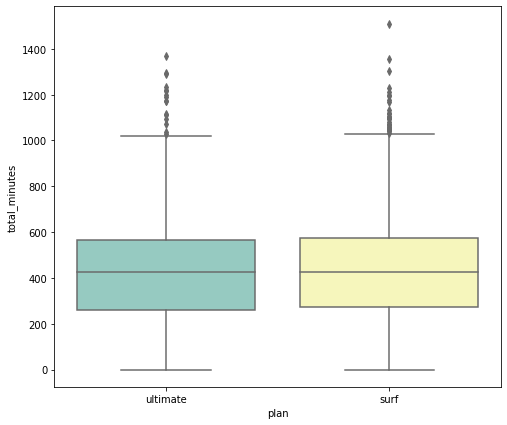

In [51]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.boxplot( x='plan',y="total_minutes",
                 data=monthly_consumed, palette="Set3")


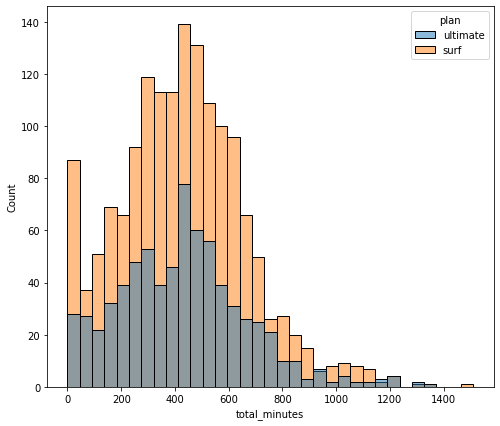

Average is 429.2834714348016
plan
surf        428.749523
ultimate    430.450000
Name: total_minutes, dtype: float64

plan
surf        234.453150
ultimate    240.508762
Name: total_minutes, dtype: float64

plan
surf        54968.279461
ultimate    57844.464812
Name: total_minutes, dtype: float64

Centered around average


In [52]:
user_behaviour('total_minutes')

From both ploting, we can concludd that:
* Both plans have upper outliers. But there are more users that use the Surf plan than Ultimate plan.
* In both plans:
    * The average minutes that a user consumed is arround to 429 minutes. 
    * The data is dispered the same arround the mean because the variance and the standard derivation are almost the same.
    * The data is centered around the mean accoding to coeffient of variance.

### `Messages`

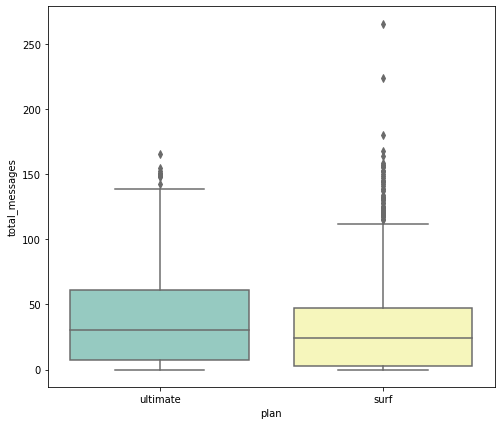

In [53]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.boxplot( x='plan',y="total_messages",
                 data=monthly_consumed, palette="Set3")

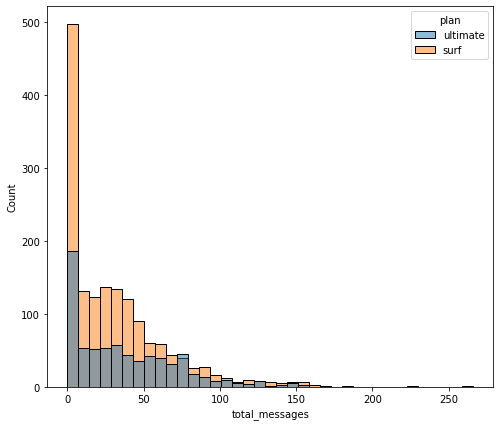

Average is 33.166593981683384
plan
surf        31.159568
ultimate    37.551389
Name: total_messages, dtype: float64

plan
surf        33.566717
ultimate    34.767179
Name: total_messages, dtype: float64

plan
surf        1126.724522
ultimate    1208.756744
Name: total_messages, dtype: float64

Varies a lot


In [54]:
user_behaviour('total_messages')

We can conclude that:
* The upper outlier of `surf` plan  is lower than in the `ultimate` plan. There is more chance that a user from `surf` plan will overcharged for minutes.
* the distribution is skewed to the right and not distributed around the mean.
* Users from Surf plan send on average 31 messages in a month in comparison to Ultimaye users who send 37 messages on average in a month.

### `Internet`

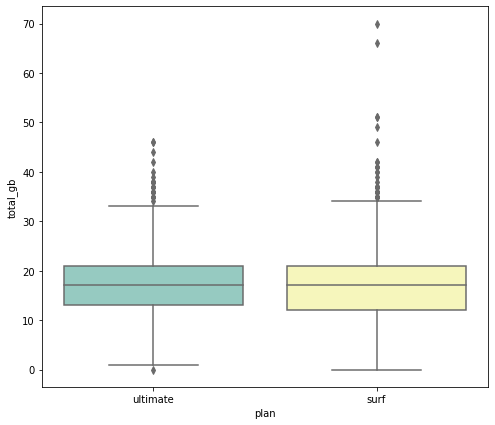

In [55]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.boxplot( x='plan',y="total_gb",
                 data=monthly_consumed, palette="Set3")

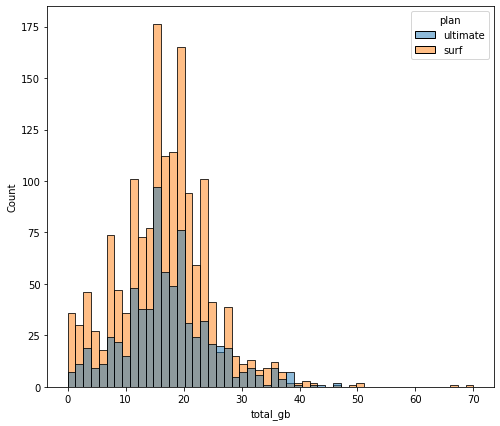

Average is 16.870475359790667
plan
surf        16.670693
ultimate    17.306944
Name: total_gb, dtype: float64

plan
surf        7.847522
ultimate    7.670108
Name: total_gb, dtype: float64

plan
surf        61.58360
ultimate    58.83055
Name: total_gb, dtype: float64

Centered around average


In [56]:
user_behaviour('total_gb')

We can conclude that:
* In both plan
    * we have the same upper outlier. But more data outside the upper outlier in the `surf` outlier.
    * the average use of data colume is 16 GB. 
    * the data is distributed around the mean according the standard derivation and variation.
    * the data is centered around the average according the coeffient of variance.
* But users from the `surf` plan have more probelaty to have extra charge for data volume.

## Revenue

Now let's use the same function `user_behaviour` to check the distribution of the `monthly_revenue` for each plan.

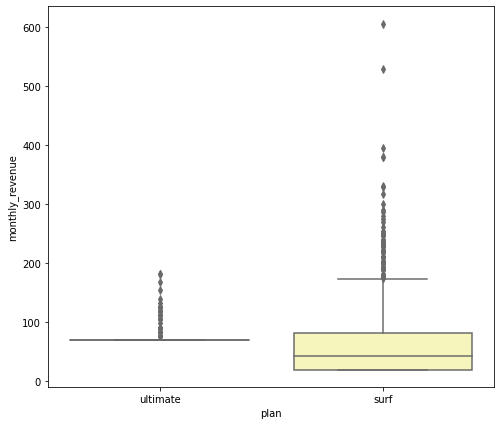

In [57]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.boxplot( x='plan',y="monthly_revenue",
                 data=monthly_consumed, palette="Set3")

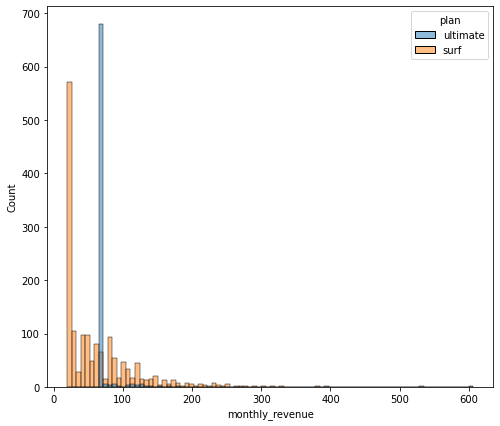

Average is 65.47165285651984
plan
surf        62.339797
ultimate    72.313889
Name: monthly_revenue, dtype: float64

plan
surf        56.356746
ultimate    11.395108
Name: monthly_revenue, dtype: float64

plan
surf        3176.082836
ultimate     129.848486
Name: monthly_revenue, dtype: float64

Centered around average


In [58]:
user_behaviour('monthly_revenue')

We can conclude that:
* most users that use `ultimate` plan did not pass the limites of their plans. The average monthly revenue for ultimate plan is 72 dollars.
* For users that use `surf` plan:
    * the average monthly revenue is 62 dollars which is higher than the monthly pay of the plan. That means that on average, users have extra charge. 
    * In the surf plan, we have a higher upper outlier than in the ultimate plan.
    * the distribution of the monthly revenue for the Surf plan is mostly around the mean while for the Ultimate plan is represented as a high and single peack.

In [59]:
# Reviewer's code

monthly_consumed.pivot_table(index='plan', values=['total_minutes', 'total_messages', 'total_mb'],
                       aggfunc=['mean', 'std', 'var'])

mean                                       std  \
              total_mb total_messages total_minutes     total_mb   
plan                                                               
surf      16558.283490      31.159568    428.749523  8013.513327   
ultimate  17214.699694      37.551389    430.450000  7851.897435   

                                                var                 \
         total_messages total_minutes      total_mb total_messages   
plan                                                                 
surf          33.566717    234.453150  6.421640e+07    1126.724522   
ultimate      34.767179    240.508762  6.165229e+07    1208.756744   

                        
         total_minutes  
plan                    
surf      54968.279461  
ultimate  57844.464812

## Test statistical hypotheses

In this part, we will test two hypothesis:
* The average revenue from users of Ultimate and Surf calling plans differs.
* The average revenue from users in NY-NJ area is different from that of the users from other regions.

For both hypothesis, we will test those both terms:
* Null hypithesis H0 - the samples are the same
* Alternative hypothesis H1 - the samples are different

To test those hypothesis, we will use the `t_test` function. This function will compare two samples with those conditons:
* The two samples are independently from one and other. Therefore, we will use `stats.ttest_ind()` method.
* Alpha equal to 0.05.
* If the two samples have equal variances using the `stats.levene()` method. If True (default), perform a standard independent 2 sample test that assumes equal population variances . If False, perform Welch’s t-test, which does not assume equal population variance.
* In case of `Nan` values, set the parameter `nan_policy` as `'omit'` to  performs the calculations by  ignoring nan values.

We can have two results from the `t_test` function:
* `'Reject H0 and accept H1: average of sample 1 is not equal to average of sample 2 because of sufficient evidence in
the sample in favor or H1' `
* `"Fail to Reject H0: We don't have enough evidence to say that averages of sample 1 and sample 2 are not the same or insufficient evidence to support H1"`

In [60]:
def t_test(sample1,sample2,alpha=0.05):
    p_value_levene=stats.levene(sample1, sample2).pvalue
    if p_value_levene<alpha:
        option_var=False
    else:
        option_var=True
    p_value=stats.ttest_ind(sample1, sample2,nan_policy='omit',equal_var=option_var).pvalue
    print(p_value)
    if p_value<alpha:
        print('Reject H0 and accept H1: average of sample 1 is not equal to average of sample 2 because of sufficient evidence in the sample in favor or H1')
    else:
        print( "Fail to Reject H0: We don't have enough evidence to say that averages of sample 1 and sample 2 are not the same or insufficient evidence to support H1") 

### The average revenue from users of Ultimate and Surf

To test the first hypothesis, we will:
* creat two filtered datas by `plan`:
    * `surf_revenue` filtered table for `'surf'` users and then extract only the `monthly_revenue` variable to a list called `sample1`.
* Same for `'ultimate'` plan as `ultimate_revenue` and `sample2`.
* Check the `t_test` result for `sample1` and `sample2`.


In [61]:
# Test the hypotheses
surf_revenue=monthly_consumed.query('plan=="surf"')
sample1=surf_revenue.monthly_revenue
sample1

1        20.0
2        60.0
3        60.0
4        90.0
5        20.0
        ...  
2285    180.0
2286    240.0
2289     20.0
2290     40.0
2291     20.0
Name: monthly_revenue, Length: 1573, dtype: float64

In [62]:
ultimate_revenue=monthly_consumed.query('plan=="ultimate"')
sample2=ultimate_revenue.monthly_revenue
sample2

0        70.0
19       84.0
20       70.0
26       70.0
27       70.0
        ...  
2231     70.0
2247     70.0
2287    112.0
2288     70.0
2292     70.0
Name: monthly_revenue, Length: 720, dtype: float64

In [63]:
t_test(sample1,sample2,alpha=0.05)

2.3330369403174417e-11
Reject H0 and accept H1: average of sample 1 is not equal to average of sample 2 because of sufficient evidence in the sample in favor or H1


We can conclude that the average of monthly revenue for Surf plan is not equal to the average of the monthly revenue for Ultimate plan.

### The average revenue from users in NY-NJ area is different 

To test the second hypothesis, we will:
* Add the `city` column from the `users` table in the method we used to add the plan by `user_id` where this information will be stored in a new table called `data_frame2`. In case of missing values, we will fill with `None` using `.fillna()` method.
* Search the `NY-NJ` variable by applying the `.unique()` method on the `city` column.
* creat two filtered datas by `plan` and the `city`:
    * `NY_NJ_revenue` filtered table for users from `"New York-Newark-Jersey City, NY-NJ-PA MSA"` and then extract only the `monthly_revenue` variable to a list called `sample3`.
* Same for users who are not from `NY-NJ` area as `other_city_revenue` and `sample4`.
* Check the `t_test` result for `sample3` and `sample4`.

In [64]:
data_frames2 = [monthly_consumed,users[['user_id','city']]]
monthly_consumed = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],
                                            how='inner'), data_frames2).fillna('None')
monthly_consumed

,user_id,month,total_calls,total_minutes,total_messages,total_mb,plan,total_gb,monthly_revenue,city
0,1000,December,16.0,124.0,11.0,1901.47,ultimate,2.0,70.0,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,August,27.0,182.0,30.0,6919.15,surf,7.0,20.0,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,December,56.0,412.0,44.0,19369.18,surf,19.0,60.0,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,November,64.0,426.0,36.0,18504.30,surf,19.0,60.0,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,October,65.0,393.0,53.0,22330.49,surf,22.0,90.0,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...,...,...
2288,1204,November,0.0,0.0,42.0,21346.95,ultimate,21.0,70.0,"Chicago-Naperville-Elgin, IL-IN-WI MSA"
2289,1349,December,0.0,0.0,61.0,13039.91,surf,13.0,20.0,"Boston-Cambridge-Newton, MA-NH MSA"
2290,1349,November,0.0,0.0,72.0,17128.26,surf,17.0,40.0,"Boston-Cambridge-Newton, MA-NH MSA"
2291,1349,October,0.0,0.0,76.0,13093.55,surf,13.0,20.0,"Boston-Cambridge-Newton, MA-NH MSA"


In [65]:
monthly_consumed.city.unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

In [66]:
NY_NJ_revenue=monthly_consumed.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')
NY_NJ_revenue

,user_id,month,total_calls,total_minutes,total_messages,total_mb,plan,total_gb,monthly_revenue,city
56,1014,December,150.0,1114.0,64.0,7792.41,surf,8.0,56.84,"New York-Newark-Jersey City, NY-NJ-PA MSA"
57,1014,November,28.0,163.0,9.0,1175.59,surf,2.0,20.00,"New York-Newark-Jersey City, NY-NJ-PA MSA"
75,1022,August,80.0,631.0,0.0,21325.33,surf,21.0,87.86,"New York-Newark-Jersey City, NY-NJ-PA MSA"
76,1022,December,82.0,585.0,0.0,18283.62,surf,18.0,55.10,"New York-Newark-Jersey City, NY-NJ-PA MSA"
77,1022,July,70.0,475.0,0.0,9933.15,surf,10.0,20.00,"New York-Newark-Jersey City, NY-NJ-PA MSA"
...,...,...,...,...,...,...,...,...,...,...
2263,1080,August,0.0,0.0,31.0,20519.74,surf,21.0,80.00,"New York-Newark-Jersey City, NY-NJ-PA MSA"
2264,1080,December,0.0,0.0,61.0,24543.42,surf,24.0,110.00,"New York-Newark-Jersey City, NY-NJ-PA MSA"
2265,1080,November,0.0,0.0,50.0,33559.88,surf,33.0,200.00,"New York-Newark-Jersey City, NY-NJ-PA MSA"
2266,1080,October,0.0,0.0,59.0,30161.57,surf,30.0,170.00,"New York-Newark-Jersey City, NY-NJ-PA MSA"


In [67]:
# Reviewer's code

monthly_consumed[monthly_consumed.city.str.contains('NY-NJ')]['monthly_revenue']

56       56.84
57       20.00
75       87.86
76       55.10
77       20.00
         ...  
2263     80.00
2264    110.00
2265    200.00
2266    170.00
2267    120.00
Name: monthly_revenue, Length: 377, dtype: float64

In [68]:
NY_NJ_revenue.monthly_revenue.describe()

count    377.000000
mean      61.193050
std       44.028772
min       20.000000
25%       20.000000
50%       57.560000
75%       74.920000
max      280.000000
Name: monthly_revenue, dtype: float64

In [69]:
sample3=NY_NJ_revenue.monthly_revenue
sample3

56       56.84
57       20.00
75       87.86
76       55.10
77       20.00
         ...  
2263     80.00
2264    110.00
2265    200.00
2266    170.00
2267    120.00
Name: monthly_revenue, Length: 377, dtype: float64

In [70]:
other_city_revenue=monthly_consumed.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')
other_city_revenue

,user_id,month,total_calls,total_minutes,total_messages,total_mb,plan,total_gb,monthly_revenue,city
0,1000,December,16.0,124.0,11.0,1901.47,ultimate,2.0,70.0,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,August,27.0,182.0,30.0,6919.15,surf,7.0,20.0,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,December,56.0,412.0,44.0,19369.18,surf,19.0,60.0,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,November,64.0,426.0,36.0,18504.30,surf,19.0,60.0,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,October,65.0,393.0,53.0,22330.49,surf,22.0,90.0,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...,...,...
2288,1204,November,0.0,0.0,42.0,21346.95,ultimate,21.0,70.0,"Chicago-Naperville-Elgin, IL-IN-WI MSA"
2289,1349,December,0.0,0.0,61.0,13039.91,surf,13.0,20.0,"Boston-Cambridge-Newton, MA-NH MSA"
2290,1349,November,0.0,0.0,72.0,17128.26,surf,17.0,40.0,"Boston-Cambridge-Newton, MA-NH MSA"
2291,1349,October,0.0,0.0,76.0,13093.55,surf,13.0,20.0,"Boston-Cambridge-Newton, MA-NH MSA"


In [71]:
other_city_revenue.monthly_revenue.describe()

count    1916.000000
mean       66.313528
std        47.923742
min        20.000000
25%        28.760000
50%        70.000000
75%        70.000000
max       606.180000
Name: monthly_revenue, dtype: float64

In [72]:
sample4=other_city_revenue.monthly_revenue
sample4

0       70.0
1       20.0
2       60.0
3       60.0
4       90.0
        ... 
2288    70.0
2289    20.0
2290    40.0
2291    20.0
2292    70.0
Name: monthly_revenue, Length: 1916, dtype: float64

In [73]:
t_test(sample3,sample4,alpha=0.05)

0.054839661555067414
Fail to Reject H0: We don't have enough evidence to say that averages of sample 1 and sample 2 are not the same or insufficient evidence to support H1


We have failed to reject the null hypothesis and do not have enough evidence to support the alternative hypothesis.

## General conclusion

In this project -
* We changed the variables type in `calls`, `messages` and `interent` into datetime type and created a new `month` colum to each of those tables to then group each of them by `user_id` and `month`.
* We merged all our data by `user_id` and `month` to get the total minutes, messages and internet traffic used by each user in each month.
* calculated the montly revenue for each month and user, especially n case of extra charge for every additional minute, message and GB.
* We examined the users behavior by calls, message, interenet traffic and monthly revenue. 
* We have rejected the hypothesis that the monthly revenue is both plan is similar therefore accepted the alternative hypothesis . While we have failed to reject the second hypothesis that the monthly revenue of NY user's is different from other reg

We can conclude that:
* most Surf users have exceed their plan's limitation and have been overcharged. Therefor, the Surf plan is more profitable.
* the monthly revenue of the users depends in their location.

We can recommand deducting an analysis on the city's influence on the monthly revenue and increase the advertisment budget on the Surf plan.